In [39]:
from keras.datasets import mnist
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys, os
%matplotlib inline
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [40]:
X_train = x_train.astype(np.float)
X_test = x_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [41]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

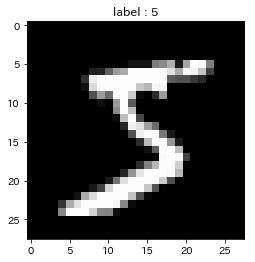

In [42]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [43]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
y_train = y_train_one_hot
y_test = y_test_one_hot

(60000,)
(60000, 10)
float64


In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape) # (48000, 784)
print(y_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [45]:
def sigmoid(X):
    return 1/ (1 + np.exp(-X))

In [46]:
def cross_entropy_error(z,y):
    return -np.sum(y * np.log(z))

In [47]:
def softmax(A):
        """
        softmap関数
        """
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A)
        return np.exp(A) / np.sum(np.exp(A))

In [48]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [49]:
class Affine:
    def __init__(self,w,b):# インスタンス変数の初期化
        self.W = w # 重みは固定
        self.b = b #　バイアスも固定
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x #入力を引数で渡す。
        out = np.dot(x, self.W) + self.b # バイアス+重みx入力の行列を渡す
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)#重みの形状の転置を行なって、それをdoutでdotする。
        self.dW = np.dot(self.x.T, dout)# 入力の形状の転置を行なって、それをdoutでdotする。
        self.db = np.sum(dout, axis=0)#バイアスはaxis=0で微分する。
        
        return dx

In [50]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [51]:
class SoftmaxWithLoss:
    def __init__(self):#インスタンス変数の初期化
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self, x, t):
        self.t = t # 教師データの代入
        self.y = softmax(x) # softmax関数の出力
        #print(self.y)
        self.loss = cross_entropy_error(self.y, self.t) # 交差エントロピー誤差の出力　引数には、softmax関数の出力
        
        return self.loss #交差エントロピー誤差のインスタンス変数を返す。
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0] #教師データの数を取得する
        dx = (self.y - self.t) / batch_size #教師データの数で割り算する。
        
        return dx

In [69]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, verbose = True):
        self.verbose = verbose

        sigma  = 0.01 # ガウス分布の標準偏差
        batch_size = 10 # バッチサイズ
        n_features = 784 # 特徴量の数
        n_nodes1 = 400 # 1層目のノード数
        n_nodes2 = 200 # 2層目のノード数
        n_output = 10 # 出力のクラス数（3層目のノード数）
        
        
        self.params = {}
        self.params['W1'] = sigma  * np.random.randn(n_features, n_nodes1) # W1入力層->第１層の重み
        self.params['b1'] = sigma  * np.random.randn(n_nodes1)# 入力層->第１層のバイアス
        self.params['W2'] = sigma * np.random.randn(n_nodes1, n_nodes2)# W2第１層->隠れ層の重み
        self.params['b2'] = sigma  * np.random.randn(n_nodes2)# 第１層->第2層のバイアス
        self.params['W3'] = sigma * np.random.randn(n_nodes2, n_output)# W3第1層->出力層の重み
        self.params['b3'] = sigma  * np.random.randn(n_output)# 第2層->出力層のバイアス
        
        
         # レイヤの生成
        self.layers = OrderedDict()#OrderedDict = 項目が追加された順序を記憶する辞書のサブクラス
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])# Affine1 入力層->第１層　重みバイアスで出力
        self.layers['Sigmoid1'] = Sigmoid() # Relu関数で、0以上のものだけを出力する。a->zのところ
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])# Affine2 重みバイアスで出力
        self.layers['Sigmoid2'] = Sigmoid() # Relu関数で、0以上のものだけを出力する。a->zのところ
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])# Affine2 重みバイアスで出力
        self.lastLayer = SoftmaxWithLoss()
    
            
    def gradient(self, x, t):
        # forward
        self.loss(x, t) #損失関数のメソッド　は、return self.lastLayer.forward(y, t)つまり、loss関数を計算して代入するだけなはず。
        
        
        # backward
        dout = 1 #損失関数->出力層への勾配 ∂L/∂Lで1
        dout = self.lastLayer.backward(dout) # 出力層の逆伝播を求める。

        layers = list(self.layers.values())#layersをリストにする。
        layers.reverse()# 逆の順番にする。
        for layer in layers:
            dout = layer.backward(dout) #各レイヤーの逆伝搬の値を算出する。

        grads ={}
        grads['W1'] = self.layers['Affine1'].dW # 各レイヤ関数に、self.dW , self.dbが組み込まれているので、backwardを実行すると各変数に代入される。
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        
        
        return grads


    # 損失関数の値を求める
    # x:入力データ、t:教師データ
    def loss(self, x, t):# 損失関数
        y = self.predict(x)#predictが出力した値をyに代入
        return self.lastLayer.forward(y, t)
    

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():# OrderedDictクラスインスタンスのvalues()メソッドでリストを表示
            X = layer.forward(X)#Affin1.forward(x), Sigmoid1.forward(x), Affine2.forward(x) , Sigmoid2.forward(x), Affine3.forward(x)でAffin3までを行う。
            
        return X # 最終的にfor構文が終わった時には、Affine3.forward(x)の結果になっているはず

In [53]:

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# 【問題2】学習曲線のプロット

0 番目のエポックのloss値  227.11582732198065
1 番目のエポックのloss値  227.51647512617234
2 番目のエポックのloss値  156.9881785743096
3 番目のエポックのloss値  89.72715062681574
4 番目のエポックのloss値  58.60081596992882
5 番目のエポックのloss値  45.2629066735541
6 番目のエポックのloss値  37.59211151478655
7 番目のエポックのloss値  32.04732369847001
8 番目のエポックのloss値  28.29498955137216
9 番目のエポックのloss値  25.44326072739034
10 番目のエポックのloss値  23.09608113299388
11 番目のエポックのloss値  21.12716315394374
12 番目のエポックのloss値  19.408008760964584
13 番目のエポックのloss値  17.85877538731837
14 番目のエポックのloss値  16.44732304166375
15 番目のエポックのloss値  15.164936003815132
16 番目のエポックのloss値  14.010232622418043
17 番目のエポックのloss値  12.978175139401035
18 番目のエポックのloss値  12.055933927519886
19 番目のエポックのloss値  11.225609865993814
20 番目のエポックのloss値  10.469641889670438
21 番目のエポックのloss値  9.774404602657203
22 番目のエポックのloss値  9.130566165746693
23 番目のエポックのloss値  8.532414319765406
24 番目のエポックのloss値  7.977309052432459
25 番目のエポックのloss値  7.4645414240516015
26 番目のエポックのloss値  6.993757030468197
27 番目のエポックのloss値  6.563995061

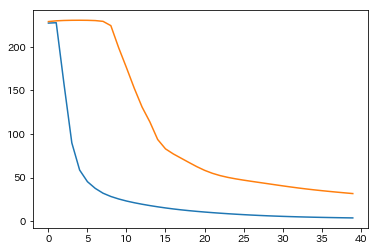

In [54]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=100)
get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=100)
ssn = ScratchSimpleNeuralNetrowkClassifier()
# print(len(get_mini_batch)) # 4800
# print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
epocs=40
train_loss_list = []
for i in range(epocs):
    for mini_X_train, mini_y_train in get_mini_batch:
        lr = 0.2
        grad = ssn.gradient(mini_X_train,mini_y_train)
        for key in ('W1','b1','W2','b2','W3','b3'):
            ssn.params[key] -= lr * grad[key]
            #print(ssn.params[key])
    loss = ssn.loss(mini_X_train,mini_y_train)
    if ssn.verbose == True:
        print(i,"番目のエポックのloss値 ",loss)
    train_loss_list.append(loss)
    
if X_val is not None and y_val is not None:
    ssn = ScratchSimpleNeuralNetrowkClassifier()
    get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=100)    
    train_loss_list_val = []
    for i in range(epocs):
        for mini_X_train, mini_y_train in get_mini_batch_val:
            lr = 0.2
            grad = ssn.gradient(mini_X_train,mini_y_train)
            for key in ('W1','b1','W2','b2','W3','b3'):
                ssn.params[key] -= lr * grad[key]
                #print(ssn.params[key])
        loss_val = ssn.loss(mini_X_train,mini_y_train)
        if ssn.verbose == True:
            print(i,"番目のエポックのloss_val値 ",loss_val)
        train_loss_list_val.append(loss_val)
   
plt.plot(train_loss_list)
plt.plot(train_loss_list_val)
plt.show()
    

    

# 推定 【問題3】指標値の算出

In [73]:
y_pred = ssn.predict(X_val)

In [74]:
y_pred = ssn.predict(X_val)
y_pred = (y_pred > (y_pred/np.sum(y_pred, axis=0)))
print(np.argmax(y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
y_pred

2
              precision    recall  f1-score   support

           0       0.35      0.99      0.52      1205
           1       0.37      1.00      0.54      1347
           2       0.15      1.00      0.26      1168
           3       0.15      1.00      0.27      1252
           4       0.26      1.00      0.41      1160
           5       0.12      1.00      0.21      1075
           6       0.25      1.00      0.40      1128
           7       0.27      1.00      0.42      1303
           8       0.12      1.00      0.21      1163
           9       0.19      1.00      0.31      1199

   micro avg       0.19      1.00      0.32     12000
   macro avg       0.22      1.00      0.36     12000
weighted avg       0.23      1.00      0.36     12000
 samples avg       0.20      1.00      0.33     12000



array([[False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [False,  True,  True, ..., False,  True, False],
       [ True, False, False, ..., False,  True, False],
       [False,  True,  True, ..., False,  True, False]])

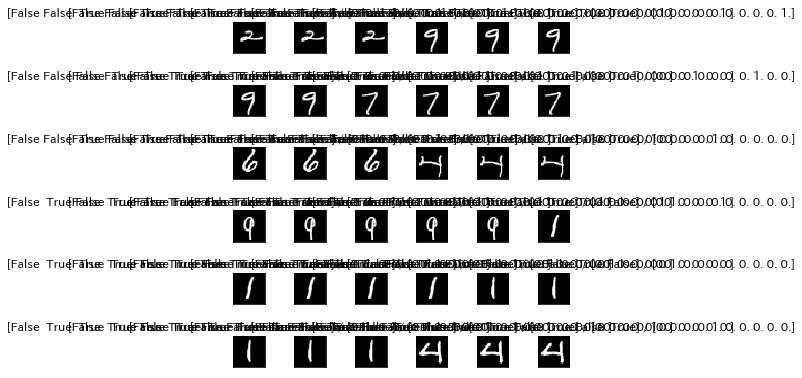

In [75]:
num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')